# Estimation and Classification Course: Final Project

## Description

Demo notebook of the Simulator and Visualizer.

In [1]:
# python modules
from os import environ
from collections import namedtuple

environ['PYGAME_HIDE_SUPPORT_PROMPT'] = '1' # used to hide pygame initial prompt

# project specific modules
from config import RunConfig, markdown_config_table
import utils
import policy

# third-party dependencies, used for visualizations in notebook
from IPython.display import HTML, Image, Markdown, display

/home/diogo/anaconda3/envs/eclass/lib/python3.9/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


## Simulation Fundamentals
Key components you need to know:
1) How to configure the simulator?
	 - See the config table in section (1) and the example code in the section (3)
2) How to access the environment models generated for each gridworld?
	- They are available in the `model_info` dictionary variable, see section (2)
3) How to run the simulator?
	- See section (3) and the `run_sample()` in `utils.py`
4) How to visualize the results? 
	- See section (4)




------




### (1) How to configure the simulator?

To learn more about the configuration and spec see: `config.py`.

Simulation run parameters and ranges are set using `RunConfig()`.

To view the details run the next cell to generate a table of the config specification:

In [2]:
print('Config Spec:')
display(Markdown(markdown_config_table))

print('Default configuration')
run_default = RunConfig()
print(run_default)
print()
print('Example configuration')
run_example = RunConfig(gridworld_dimensions=30, obstacle_ratio=.1, max_steps=50, dummy=False)
print(run_example)

Config Spec:


| variable name | data-type/format | input value/range | default value |
| --- | --- | --- | --- |
| `gridworld_dimensions` | `int` | 5-100 | 20 |
| `obstacle_ratio` | `float` | 0.0-1.0 | 0.0 |
| `max_steps` | `int` | 1-100 | 100 |
| `robot_policy` | `Agent` | Agent | policy.Random |
| `dummy` | `bool` | [True, False] | True |
| `init_prob_mode` | `str` | {} | 'uniform' |

Default configuration
RunConfig(gridworld_dimensions=20, obstacle_ratio=0.0, max_steps=100, robot_policy=policy.Random, dummy=True, init_prob_mode='uniform')

Example configuration
RunConfig(gridworld_dimensions=30, obstacle_ratio=0.1, max_steps=50, robot_policy=policy.Random, dummy=False, init_prob_mode='uniform')





------




### (2) How to access the environment models generated for each gridworld?

A new randomly generated world is created when `.reset()` is called, where the environment provides all the models in `model_info`. 

**Note**: `priviledged_info` contains the ground-truth information and is only used for evaluation/testing purposes.


`model_info`: dictionary of model information provided by the environment. Contains:
- **transition_matrix**: 
	- numpy array of shape $(N\times N, N\times N)$, state transition $P(x_t | x_{t-1})$
- **observation_matrix**: 
	- numpy array of shape $(N\times N, Z)$, observation likelihoods $P(o_t | x_t)$
- **grid_shape**: 
	- $(N,N)$ tuple of the gridworld dimensions
- **num_states**: 
	- $N \times N$ total number of possible states (includes obstacles)
- **obs_id_lookup**: 
	- map of raw obs tuple $(N, E, S, W)$ to column index in observation matrix
- **obs_id_reverse_lookup**: 
	- map of column index in observation matrix to raw obs tuple $(N, E, S, W)$
- **state_id_to_xy**: 
	- map of state row/col id (equivalent to row/col since T is symmetric) to `np.array(x,y)`
- **xy_to_state_id**: 
	- map of tuple $(x,y)$ state to state row/col id (equivalent to row/col since T is symmetric). Note: tuple $(x,y)$ is used as key because numpy arrays cannot be hashed for a lookup key.


**Visualization**: 
- **Left**: global state where black cells are obstacles and white cells are free, blue circle is the omnidirectional robot. 
- **Right**: obstacle sensors providing sensing of obstacles one cell-away on cardinal directions (N,E,S,W).



------- 

transition_matrix shape:  (400, 400) 

observation_matrix shape:  (400, 16) 

grid_shape:  (20, 20) 

num_states:  400 

------- 

obs_id_lookup: 16 keys (showing first 3)
	{(0, 0, 0, 0): 0, (0, 0, 0, 1): 1, (0, 0, 1, 0): 2, ...}
obs_id_reverse_lookup: 16 keys (showing first 3)
	{0: (0, 0, 0, 0), 1: (0, 0, 0, 1), 2: (0, 0, 1, 0), ...}
state_id_to_xy: 400 keys (showing first 3)
	{0: [0 0], 1: [0 1], 2: [0 2], ...}
xy_to_state_id: 400 keys (showing first 3)
	{(0, 0): 0, (0, 1): 1, (0, 2): 2, ...}
------- 

Priviledged information (to not be used in your solution): {'agent_position': array([4, 1])}
------- 

Example observation: (0, 0, 1, 0) 

Example state: [4 1] 



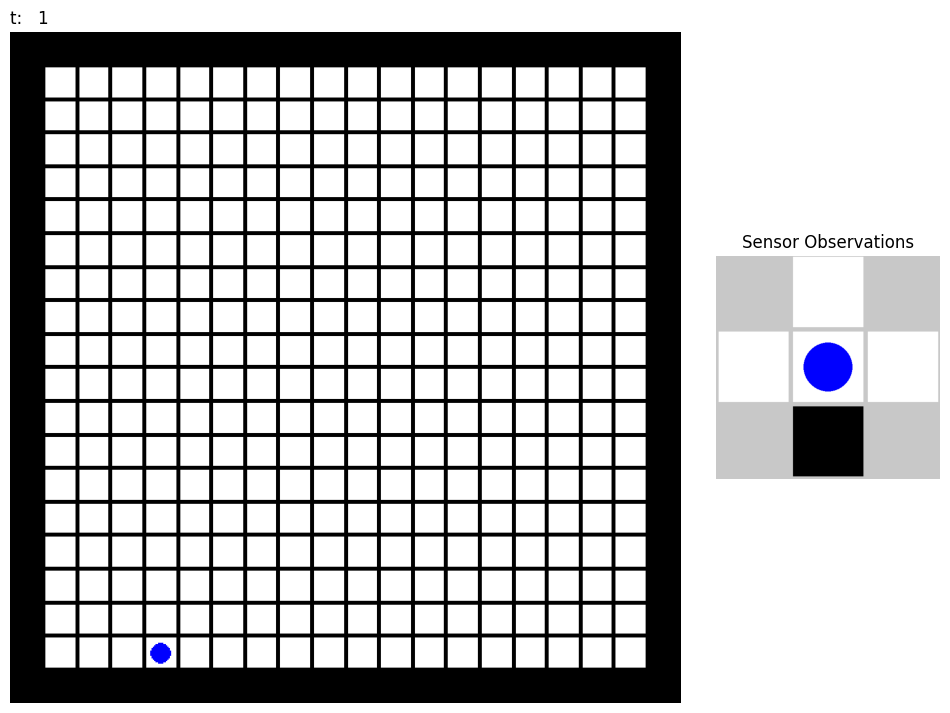

In [3]:
test_env = utils.load_env(run_default.gridworld_dimensions, run_default.obstacle_ratio)
observation, priviledged_info, model_info = test_env.reset()
print('-------','\n')
print('transition_matrix shape: ',model_info['transition_matrix'].shape,'\n')
print('observation_matrix shape: ',model_info['observation_matrix'].shape,'\n')
print('grid_shape: ',model_info['grid_shape'],'\n')
print('num_states: ', model_info['num_states'],'\n')
print('-------','\n')
utils.preview_dict('obs_id_lookup',model_info)
utils.preview_dict('obs_id_reverse_lookup',model_info)
utils.preview_dict('state_id_to_xy',model_info)
utils.preview_dict('xy_to_state_id',model_info)

print('-------','\n')
print('Priviledged information (to not be used in your solution):',priviledged_info)
print('-------','\n')

print('Example observation:',observation,'\n')
print('Example state:',priviledged_info['agent_position'],'\n')
test_env.render()




------




### (3) How to run the simulator?

- First you must implement `calculate_transition_matrix()` and `calculate_observation_matrix()` in `environment.py`
- Specify the experiments you would like to run, an example below shows you how to run multiple, then call `run_sample()`
- If successful an animation and the `index.html` file will be generated to be visualized (see section (4))

**Note**: Make sure to set `dummy=False` when you are ready to test your implementation.

In [4]:
run_0 = RunConfig(gridworld_dimensions=20, 
				  obstacle_ratio=.1, 
				  max_steps=100, 
				  dummy=False, # <- make sure you check the state of this flag when testing your implementation
				  init_prob_mode='uniform'
				  )
runs = [run_0]

## -----------------------------------------
## uncomment to execute multiple runs
# run_0 = RunConfig(20, 0.0, 100, dummy=True) 
# run_1 = RunConfig(20, 0.3, 100, dummy=True) 
# run_2 = RunConfig(20, 0.5, 100, dummy=True)
# run_3 = RunConfig(30, 0.3, 100, dummy=True)
# run_4 = RunConfig(30, 0.5, 100, dummy=True)
# runs = [run_0, run_1, run_2, run_3, run_4]
## -----------------------------------------

filename_template = 'grid-N{}__obstacles-{:.1f}__maxsteps-{}__policy-{}__dummy-{}'
for run in runs:
	run_name = filename_template.format(run.gridworld_dimensions, run.obstacle_ratio, run.max_steps, run.robot_policy.name, run.dummy)
	run_gif_path = utils.run_sample(run_name, run)
	if run_gif_path is not None:
		with open(run_gif_path,'rb') as f:
			display(Image(data=f.read(), format='png'))
		print('Completed run: {}'.format(run_name))
		# regenerate index for visulizer
		utils.generate_index()

Filtering


AttributeError: 'NoneType' object has no attribute 'shape'




------




### (4) How to visualize the results? 

After running an experiment make sure to also run `utils.generate_index()`, this will update the visualizer. This step is already done in the previous cell. 

Visualizer, how to use:
- **Drop-down**: select simulation run
- **Playback**: step over frames (previous, play/pause, next, reset)
- **Visualization**: black obstacles and white free-cells, blue robot is omnidirectional, obstacle sensors only provide information on cardinal directions (N,E,S,W).

**Note**: If the HTML does not render in your notebook, drag & drop the `index.html` file to your web browser. 

In [6]:
# load the HTML file
html_file_path = 'index.html'
with open(html_file_path, 'r', encoding='utf-8') as file:
    html_content = file.read()

In [7]:
HTML(html_content)